# Tutorial: Physical Activity Monitoring

**Author:** Julius Welzel

**Last update:** Thu 04 Apr 2024

## Learning objectives  
By the end of this tutorial, you will be able to:  

- Load accelerometer data from a raw recording
- Apply the Physical Activity Monitoring algorithm to classify activity intensity levels.  
- Interpret the results of activity classification.  
- Visualize the activity intensity levels over time. 

# Pam Physical Activity Monitoring

This example serves as a reference on how to use the physical activity monitoring algorithm. This example can be cited by referencing the package.

The example illustrates how the physical activity monitoring algorithm determines the intensity level of sedentary, light, moderate, and vigorous physical activities using body acceleration recorded with a triaxial accelerometer worn on the wrist. The physical activity monitoring algorithm is implemented in the main module [`kielmat.modules.pam._pam`](https://github.com/neurogeriatricskiel/KielMAT/tree/main/kielmat/modules/pam/_pam.py).

The algorithm determines the intensity level of physical activities based on the following steps:

1. **Loading Data:** Start by loading the data, including a time index along with accelerometer data (N, 3) for x, y, and z axes. The other inputs are the sampling frequency of the data (sampling_freq_Hz), defaulting to 100 Hz, and thresholds (thresholds_mg), provided as a dictionary containing threshold values for physical activity detection in mg unit. Another input is the epoch duration (epoch_duration_sec) in seconds, defaulting to 5 seconds. The last input, plot_results, when set to True, generates a plot showing the average Euclidean Norm Minus One (ENMO) per hour for each date, with a default of True.

2. **Preprocessing:** The input signal is preprocessed by calculating the sample-level Euclidean norm (EN) of the acceleration signal across the x, y, and z axes. A fourth-order Butterworth low-pass filter with a cut-off frequency of 20Hz is then applied to remove noise. This filter is applied to the vector magnitude scores. The ENMO index is calculated to separate the activity-related component of the acceleration signal. Negative ENMO values are truncated to zero. Finally, the indices are multiplied by 1000 to convert units from g to mg.

3. **Classification:** The algorithm classifies the intensity of physical activities based on the calculated ENMO values. The activity_classification function expresses the ENMO time-series data in 5-second epochs for summarizing the data. Thresholds for categorization are as follows: sedentary activity < 45 mg, light activity 45–100 mg, moderate activity 100–400 mg, vigorous activity > 400 mg.

4. **Results:** The algorithm classifies different levels of activities along with the time spent on each activity level for each day. If `plot_results` is set to True, the function generates a plot showing the averaged ENMO values for each day.

#### References
[`1`] Doherty, Aiden, et al. (2017). Large scale population assessment of physical activity using wrist-worn accelerometers: the UK biobank study. PloS one 12.2. [https://doi.org/10.1371/journal.pone.0169649](https://doi.org/10.1371/journal.pone.0169649)

[`2`] Van Hees, Vincent T., et al. (2013). Separating movement and gravity components in an acceleration signal and implications for the assessment of human daily physical activity. PloS one 8.4. [https://doi.org/10.1371/journal.pone.0061691](https://doi.org/10.1371/journal.pone.0061691)


## Import Libraries
The necessary libraries such as pandas, physical activity monitoring and fairpark data loader are imported. Make sure that you have all the required libraries and modules installed before running this code. You may also need to install the `kielmat` library and its dependencies if you haven't already.


In [1]:
import pandas as pd
import os
from pathlib import Path
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from kielmat.modules.pam import PhysicalActivityMonitoring
from kielmat.utils.kielmat_dataclass import KielMATRecording # Import the KielMATRecording class
from kielmat.config import cfg_colors

## Data Preparation

To implement the physical activity monitoring algorithm, we load example data from a participant who has worn a wrist IMU sensor for several hours during a day while performing daily life activities at home.

The data, including a time index and accelerometer data (N, 3) for the x, y, and z axes, is loaded as a pandas DataFrame.

In [2]:
# The 'file_path' variable holds the absolute path to the data file
file_path = r".\data\exAccelDataMobilise.csv"

# Set the filepath
file_path = Path(os.getcwd()).parent.joinpath("examples","data","exAccelDataMobilise.csv")

# read the csv data
acc_data = pd.read_csv(file_path)

# specifiy the sampling rate
fs = 100 # Hz

n_channels = acc_data.shape[1]
n_samples = acc_data.shape[0]

# check how many minutes of data we have
n_minutes = n_samples/fs/60
print(f"Minutes of data: {n_minutes:.2f}")


Minutes of data: 18.33


In [3]:
# construct the channel information

tracked_point = "lowerBack"

n_channels = acc_data.shape[1] # second dimension of the data represents the number of channels

col_names = [
    f"{tracked_point}_{s}_{x}"
    for s in ["ACCEL"]
    for x in ["x", "y", "z"]
]

# Make the channel dictionary following the BIDS naming conventions
channels_dict = {
    "name": col_names,
    "component": ["x", "y", "z"] * (n_channels // 3),
    "type": ["ACCEL"] * (n_channels),
    "tracked_point": [tracked_point] * n_channels,
    "units": ["m/s^2"] * n_channels,
    "sampling_frequency": [fs] * n_channels,
}

recording =  KielMATRecording(
    data={"lb_imu": acc_data}, channels={"lb_imu": pd.DataFrame(channels_dict)}
)

## Apply Physical Activity Monitoring Algorithm
Now, we are running the physical activity monitoring algorithm from the main module [`kielmat.modules.pam._pam`](https://github.com/neurogeriatricskiel/KielMAT/tree/main/kielmat/modules/pam/_pam.py). The inputs of the algorithm are as follows:

- **Input Data:** `data` Includes data with a time index along with accelerometer data (N, 3) for x, y, and z axes in pandas Dataframe format.
- **Acceleration Unit:** `acceleration_unit` is the unit of the acceleration data.
- **Sampling Frequency:** `sampling_freq_Hz` is the sampling frequency of the acceleration data, defined in Hz, with a default value of 100 Hz.
- **Thresholds:** `thresholds_mg` are provided as a dictionary containing threshold values for physical activity detection in mili-g.
- **Epoch Duration:** `epoch_duration_sec` is the epoch length in seconds, with a default value of 5 seconds.
- **Plot Results:** `plot_results`, if set to True, generates a plot showing the average Euclidean Norm Minus One (ENMO) per hour for each day. The default is True.

To apply the physical activity monitoring algorithm, an instance of the PhysicalActivityMonitoring class is created using the constructor, `PhysicalActivityMonitoring()`. The `pam` variable holds the instance, allowing us to access its methods. The output of the algorithm includes information regarding physical activity levels and the time spent on each activity for the provided date, including the mean of sedentary time, light, moderate, and vigorous activities, along with the time spent for each of them.

In [4]:
import datetime

# Set the start time to today at 9 AM
start_time = datetime.datetime.now().replace(hour=9, minute=0, second=0, microsecond=0)

# Calculate the end time based on the number of samples and the sampling rate
end_time = start_time + datetime.timedelta(seconds=n_samples / fs)

# Create the datetime index using pd.date_range()
index = pd.date_range(start=start_time, end=end_time, periods=n_samples)

# Add the datetime index as a new column to the DataFrame
recording.data["lb_imu"]["timestamp"] = index

# set as index the datetime column
recording.data["lb_imu"].set_index("timestamp", inplace=True)
recording.data["lb_imu"]

,0,1,2
timestamp,,,
2024-04-03 09:00:00.000000000,0.969647,-0.033464,-0.001778
2024-04-03 09:00:00.010000090,0.970406,-0.036270,-0.000252
2024-04-03 09:00:00.020000181,0.973402,-0.040885,0.000498
2024-04-03 09:00:00.030000272,0.972774,-0.038731,0.005013
2024-04-03 09:00:00.040000363,0.974063,-0.036836,-0.001207
...,...,...,...
2024-04-03 09:18:19.959999636,0.970364,0.024569,0.095281
2024-04-03 09:18:19.969999727,0.968783,0.023735,0.095931
2024-04-03 09:18:19.979999818,0.969204,0.027664,0.098075


C:\Users\User\Desktop\kiel\KielMAT\kielmat\utils\preprocessing.py:1040: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  processed_data = input_data.groupby(pd.Grouper(freq=f"{epoch_duration}S")).mean()


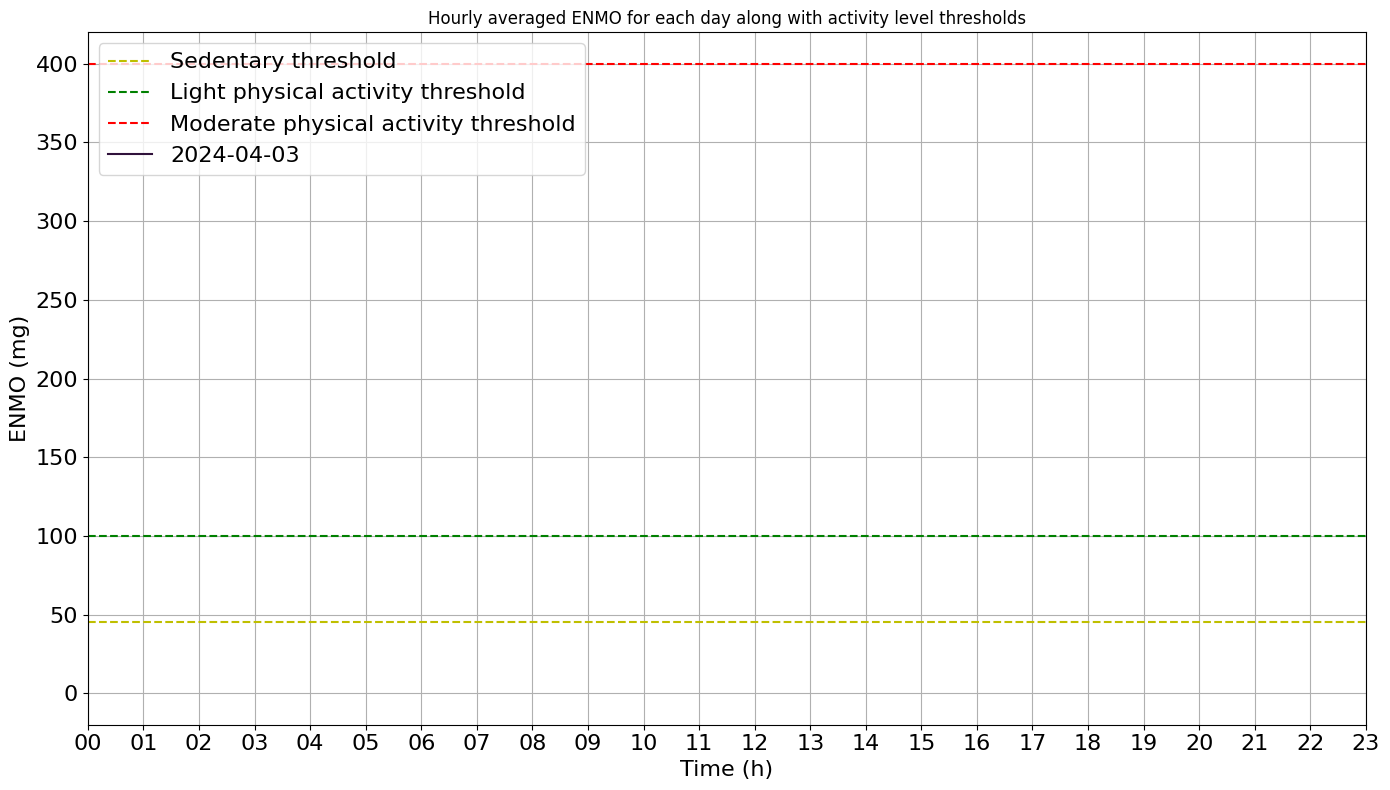

Physical Activities:          date  sedentary_mean_enmo  sedentary_time_min  light_mean_enmo  \
0  2024-04-03                  0.0           18.416667              NaN   

   light_time_min  moderate_mean_enmo  moderate_time_min  vigorous_mean_enmo  \
0             0.0                 NaN                0.0                 NaN   

   vigorous_time_min  
0                0.0  


In [5]:
# Create an instance of the PhysicalActivityMonitoring class
pam = PhysicalActivityMonitoring()

# Call phyisical activity monitoring using pam.detect
pam = pam.detect(
    data=recording.data["lb_imu"],
    acceleration_unit=recording.channels['lb_imu']['units'][0],
    sampling_freq_Hz=fs,
    thresholds_mg={
        "sedentary_threshold": 45,
        "light_threshold": 100,
        "moderate_threshold": 400,
    },
    epoch_duration_sec=5,
    plot=True,
)

# Phyisical activity information are stored in physical_activities_ attribute of pam
physical_activities = pam.physical_activities_

# Print daily phyisical activity information
print("Physical Activities:", physical_activities)